In [1]:
import os
os.chdir("/nas/ucb/oliveradk/diverse-gen/")

In [2]:
from collections import defaultdict
from pathlib import Path
import itertools
from typing import Optional
import json

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
from omegaconf import OmegaConf

from diverse_gen.utils.exp_utils import get_conf_dir
from diverse_gen.utils.proc_data_utils import get_exp_metrics


In [3]:
MAIN_DIR = "output/cc_mix_rate/main"
NO_SCHED_DIR = "output/cc_mix_rate/no-sched"
INV_AGG_DIR = "output/cc_mix_rate/inv_agg"

RESULTS_DIR = "results/cc_mix_rate"
os.makedirs(RESULTS_DIR, exist_ok=True)


In [4]:
SEEDS = [1, 2, 3]
MIX_RATES = [0.1, 0.25, 0.5, 0.75, 1.0]
DATASETS = [
    "toy_grid", 
    "fmnist_mnist", 
    "cifar_mnist", 
    "waterbirds", 
    "celebA-0", 
    "multi-nli"
]
METHODS = [
    "TopK_0.1", 
    "TopK_0.5", 
    "DivDis", 
    "DBAT", 
    "ERM"
]

In [5]:
# TODO: add change this to use current approach (just get all the data at once)
# then plot the single and aggregate correlations

In [6]:
configs = [
    (dataset, method, mix_rate, seed) 
    for dataset, method, mix_rate, seed in itertools.product(DATASETS, list(set(METHODS) - {"ERM"}), MIX_RATES, SEEDS)
]
configs.extend([
    (dataset, "ERM", 0.0, seed)
    for dataset, seed in itertools.product(DATASETS, SEEDS)
])

def get_results(configs: list[tuple[str, str, float, int]], parent_dir: str = MAIN_DIR, select_epoch: bool = True) -> list[dict]:
    results = []
    for dataset, method, mix_rate, seed in configs:
        exp_dir = get_conf_dir((dataset, method, mix_rate, seed), parent_dir)
        metric_file = os.path.join(exp_dir, "metrics.json")
        with open(metric_file, "r") as f:
            metrics = json.load(f)
        if select_epoch: 
            if dataset == "toy_grid": 
                idxs = [len(metrics["val_loss"]) - 1]
            else: 
                if method == "DBAT":
                    idxs = [np.argmin(metrics["val_source_loss"])]
                else: 
                    idxs = [np.argmin(metrics["val_loss"])]
        else: 
            idxs = range(len(metrics["val_loss"]))
        
        for idx in idxs: 
            min_val_loss = metrics["val_loss"][idx]

            source_acc_0 = metrics["val_source_acc_0"][idx]
            source_acc_1 = metrics["val_source_acc_1"][idx]
            mean_source_acc = np.mean([source_acc_0, source_acc_1])
            max_source_acc = max(source_acc_0, source_acc_1)

            source_loss = metrics["val_source_loss"][idx]

            target_acc_0 = metrics["val_target_acc_0"][idx]
            target_acc_1 = metrics["val_target_acc_1"][idx]
            max_target_acc = max(target_acc_0, target_acc_1)

            test_acc_0 = metrics["test_acc_0"][idx]
            test_acc_1 = metrics["test_acc_1"][idx]
            max_test_acc = max(test_acc_0, test_acc_1)

            worst_acc_0 = metrics["test_worst_acc_0"][idx]
            worst_acc_1 = metrics["test_worst_acc_1"][idx]
            max_worst_acc = max(worst_acc_0, worst_acc_1)

            test_acc_alt_0 = metrics["test_acc_alt_0"][idx]
            test_acc_alt_1 = metrics["test_acc_alt_1"][idx]
            max_test_acc_alt = max(test_acc_alt_0, test_acc_alt_1)

            multi_label_test_acc = np.mean([max_test_acc, max_test_acc_alt])

            result_dict = {
                "Dataset": dataset,
                "Method": method,
                "Mix_Rate": mix_rate,
                "Seed": seed,
                "val_loss": min_val_loss,
                "source_acc": mean_source_acc,
                "source_loss": source_loss,
                "target_acc": max_target_acc,
                "acc": max_test_acc,
                "acc_alt": max_test_acc_alt,
                "worst_acc": max_worst_acc,
                "multi_label_acc": multi_label_test_acc,
                "epoch": idx,
            }
            results.append(result_dict)

    df = pd.DataFrame(results)
    return df
df = get_results(configs, MAIN_DIR)
df.to_csv(os.path.join(RESULTS_DIR, "results.csv"), index=False)


# Main Results

In [7]:
acc_df = df.copy().rename(columns={"acc": "Accuracy"})
alt_acc_df = df.copy().rename(columns={"acc_alt": "Accuracy"})
worst_acc_df = df.copy().rename(columns={"worst_acc": "Accuracy"})


In [8]:
FIGSIZE = (3., 2.5)
FONTSIZE = 12
TICK_FONTSIZE = 10

# use standard matplotlib colors
color_map = plt.rcParams['axes.prop_cycle'].by_key()['color']
METHOD_COLORS = {
    "TopK_0.1": color_map[0], 
    "DivDis": color_map[1],
    "TopK_0.5": color_map[2], 
    "TopK_0.1_No_Sched": "#1e3d8f", 
    "TopK_0.5_No_Sched": "#556b2f", 
    "TopK_0.1_Inv_Agg": "#1e3d8f", 
    "TopK_0.5_Inv_Agg": "#556b2f", 
    "TopK_0.1_Comb": "#1e3d8f", 
    "TopK_0.5_Comb": "#556b2f", 
    "DBAT": color_map[3], 
    "ERM": color_map[4], 
}

DATASET_TITLES = {
    "toy_grid": "Toy Grid",
    "fmnist_mnist": "FMNIST+MNIST",
    "cifar_mnist": "CIFAR+MNIST",
    "waterbirds": "Waterbirds",
    "celebA-0": "CelebA",
    "multi-nli": "MultiNLI"
}

METHOD_TITLES = {
    "TopK_0.1": "TopK 0.1",
    "TopK_0.5": "TopK 0.5",
    "DivDis": "DivDis",
    "DBAT": "DBAT",
    "ERM": "ERM",
    "TopK_0.1_No_Sched": "TopK 0.1 Const",
    "TopK_0.5_No_Sched": "TopK 0.5 Const",
    "TopK_0.1_Inv_Agg": "TopK 0.1 Inv",
    "TopK_0.5_Inv_Agg": "TopK 0.5 Inv",
    "TopK_0.1_Comb": "TopK 0.1 Comb",
    "TopK_0.5_Comb": "TopK 0.5 Comb",
}

In [9]:
def plot_acc_results_grid(
    df: pd.DataFrame,
    nrows: int = 2,
    ncols: int = 3,
    figsize: tuple[float, float] = (6, 4),
    ylim: tuple[float, float] = (0.5, 1.0),
    fontsize: int = 10,
    tick_fontsize: int = 8,
    legend_fontsize: int = 8,
    xlabel: str = "Mix Rate",
    ylabel: str = "Accuracy",
    dataset_titles: dict[str, str] = {},
    datasets: list[str] = DATASETS, 
    methods: list[str] = METHODS, 
    legend_bbox: tuple[float, float] = (0.5, 1.05), 
    method_linestyle: dict[str, str] = {},
    method_colors: dict[str, str] = METHOD_COLORS,
):
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()
    
    for idx, dataset in enumerate(datasets):  # Using global DATASETS
        ax = axes[idx]
        dataset_data = df[df['Dataset'] == dataset]
        
        for method in methods:  # Using global METHODS
            method_data = dataset_data[dataset_data['Method'] == method]
            
            if method == "ERM":
                # For ERM, calculate mean and std of all results
                mean_acc = method_data['Accuracy'].mean()
                std_acc = method_data['Accuracy'].std()
                means = [mean_acc] * len(MIX_RATES)
                stds = [std_acc] * len(MIX_RATES)
                line_style = '--'
                marker = None
            else:
                # For other methods, group by mix rate
                grouped = method_data.groupby('Mix_Rate')['Accuracy']
                means = []
                stds = []
                for rate in MIX_RATES: 
                    rate_data = grouped.get_group(rate)
                    means.append(rate_data.mean())
                    stds.append(rate_data.std())
                line_style = method_linestyle.get(method, '-')
                marker = 'o'
            
            ax.plot(MIX_RATES, means, label=METHOD_TITLES[method], marker=marker, linestyle=line_style, color=method_colors[method])
            ax.fill_between(MIX_RATES, 
                          [m - s for m, s in zip(means, stds)],
                          [m + s for m, s in zip(means, stds)],
                          alpha=0.2, 
                          color=method_colors[method])

        x_labels = [str(mix_rate) for mix_rate in MIX_RATES]
        ax.set_xticks(MIX_RATES)
        ax.set_xticklabels(x_labels, fontsize=tick_fontsize)
        ax.tick_params(axis='both', labelsize=tick_fontsize)
        title = dataset_titles.get(dataset, dataset) if dataset_titles else dataset
        ax.set_title(title, fontsize=fontsize)
        ax.set_ylim(*ylim)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # Add a single legend for the entire figure
    handles, labels = axes[0].get_lines(), [line.get_label() for line in axes[0].get_lines()]
    fig.legend(handles, labels, loc='center', bbox_to_anchor=legend_bbox, ncol=len(methods), fontsize=fontsize)

    fig.supxlabel(xlabel, fontsize=fontsize)
    fig.supylabel(ylabel, fontsize=fontsize)
    
    fig.tight_layout()
    return fig, axes

In [10]:
def plot_aggregate_metrics(
    df: pd.DataFrame,
    included_methods: list[str] = [],
    figsize: tuple[float, float] = (6, 3),
    save_path: Optional[str] = None,
    metric_col: str = 'Accuracy',
    ylim: tuple[float, float] = (-0.1, 1.0), 
    width: float = 0.75,  # Made width a parameter with a smaller default
    title: Optional[str] = None, 
    ylabel: Optional[str] = None, 
    legend_bbox: tuple[float, float] = (0.5, 1), 
    method_colors: dict[str, str] = METHOD_COLORS,
):
    # Get ERM baseline for each dataset
    erm_baselines = df[df['Method'] == 'ERM'].groupby('Dataset')[metric_col].mean()
    
    # Filter for included methods and calculate differences from ERM baseline
    method_df = df[df['Method'].isin(included_methods)].copy()
    method_df['Accuracy_Diff'] = method_df.apply(
        lambda row: row[metric_col] - erm_baselines.get(row['Dataset'], 0), 
        axis=1
    )

    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Set y-limits
    ax.set_ylim(ylim)

    # Calculate positions for box plots
    mix_rates = sorted(method_df['Mix_Rate'].unique())
    x = np.arange(len(mix_rates))
    x = x * (len(included_methods) + 1)  # Increase spacing between mix rate groups
    
    # Plot boxes for each method
    box_positions = []
    box_data = []
    labels = []
    colors = []
    
    for i, method in enumerate(included_methods):
        for j, mix_rate in enumerate(mix_rates):
            data = method_df[(method_df['Method'] == method) & 
                           (method_df['Mix_Rate'] == mix_rate)]['Accuracy_Diff']
            if len(data) > 0:
                pos = x[j] + width * (i - len(included_methods)/2 + 0.5)
                box_positions.append(pos)
                box_data.append(data)
                labels.append(METHOD_TITLES[method])
                colors.append(method_colors[method])

    # Create box plot
    boxes = ax.boxplot(box_data, positions=box_positions, patch_artist=True,
                      medianprops=dict(color='black'),
                      whiskerprops=dict(linestyle='--', color='black'),
                      flierprops=dict(marker='o', markerfacecolor='gray', markersize=4),
                      widths=width)  # Set box width
    
    # Color the boxes according to method
    for box, color in zip(boxes['boxes'], colors):
        box.set_facecolor(color)
        box.set_alpha(0.6)
    
    # Add horizontal line at y=0
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.2)
    
    if ylabel is None: 
        ylabel = 'Accuracy Difference from ERM'
    ax.set_title(title)
    
    # Update x-axis ticks to be centered for each mix rate group
    # tick_positions = [x[i] + (len(included_methods) - 1) * width/2 for i in range(len(mix_rates))]
    ax.set_xticks(x)
    ax.set_xticklabels([f'{mr:.2f}' for mr in mix_rates], rotation=0)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Mix Rate')

    # Create custom legend
    legend_elements = [Patch(facecolor=method_colors[method], alpha=0.6, label=METHOD_TITLES[method])
                      for method in included_methods]
    ax.legend(handles=legend_elements, bbox_to_anchor=legend_bbox, 
             loc='upper center', ncol=len(included_methods))

    plt.tight_layout()
    
    if save_path:
        base, ext = os.path.splitext(save_path)
        new_save_path = f"{base}_boxplot{ext}"
        fig.savefig(new_save_path, bbox_inches="tight", dpi=300)
    
    plt.show()
    
    return fig, ax

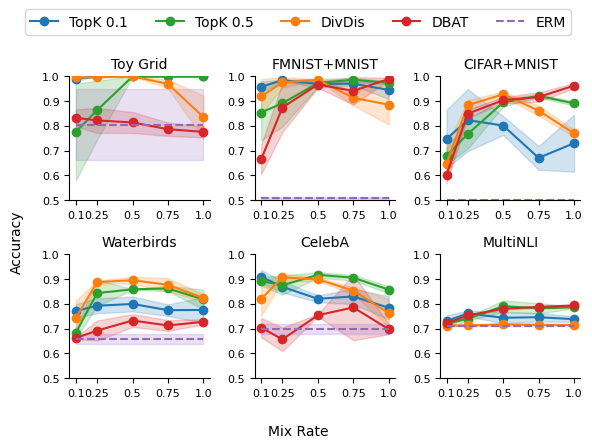

In [11]:
fig, axes = plot_acc_results_grid(
    acc_df, 
    dataset_titles=DATASET_TITLES, 
    ylabel="Accuracy", 
    figsize=(6, 4), 
    fontsize=10, 
    tick_fontsize=8, 
    legend_fontsize=8, 
    legend_bbox=(0.5, 1.05)
)
fig.savefig(os.path.join(RESULTS_DIR, "acc_grid.svg"), bbox_inches="tight", dpi=300)
plt.show()

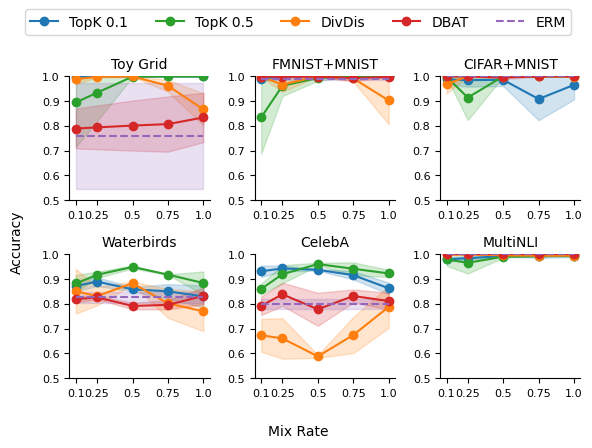

In [12]:
fig, axes = plot_acc_results_grid(
    alt_acc_df, 
    dataset_titles=DATASET_TITLES, 
    ylabel="Accuracy", 
    figsize=(6, 4), 
    fontsize=10, 
    tick_fontsize=8, 
    legend_fontsize=8, 
    legend_bbox=(0.5, 1.05)
)
fig.savefig(os.path.join(RESULTS_DIR, "alt_acc_grid.svg"), bbox_inches="tight", dpi=300)
plt.show()

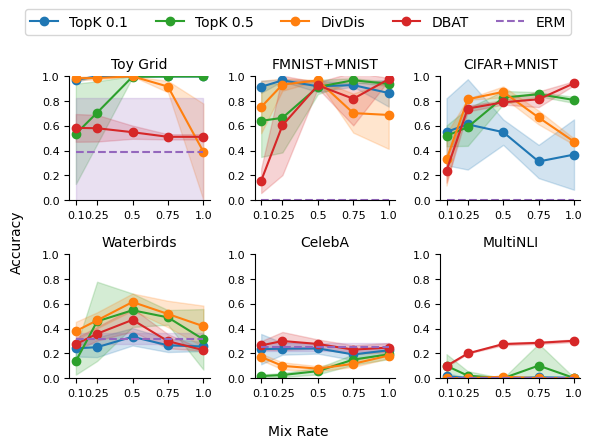

In [13]:
fig, axes = plot_acc_results_grid(
    worst_acc_df, 
    dataset_titles=DATASET_TITLES, 
    ylabel="Accuracy", 
    figsize=(6, 4), 
    ylim=(0.0, 1.0),
    fontsize=10, 
    tick_fontsize=8, 
    legend_fontsize=8, 
    legend_bbox=(0.5, 1.05)
)
fig.savefig(os.path.join(RESULTS_DIR, "worst_acc_grid.svg"), bbox_inches="tight", dpi=300)
plt.show()

In [14]:
avg_acc_df = df.copy().rename(columns={"multi_label_acc": "Accuracy"})

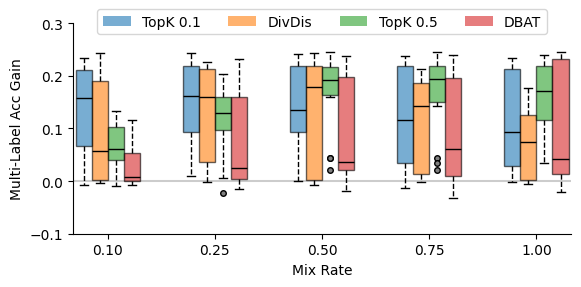

In [15]:
# For average accuracy
fig, ax = plot_aggregate_metrics(
    df=avg_acc_df,
    included_methods=["TopK_0.1", "DivDis", "TopK_0.5", "DBAT"],
    metric_col='Accuracy',
    # use_quartiles=False, 
    ylim=(-0.1, 0.3), 
    figsize=(6, 3), 
    width=0.75,
    title="", 
    ylabel="Multi-Label Acc Gain", 
    legend_bbox=(0.5, 1.1)
)
fig.savefig(os.path.join(RESULTS_DIR, "avg_acc_boxplot.svg"), bbox_inches="tight", dpi=300)
plt.show()

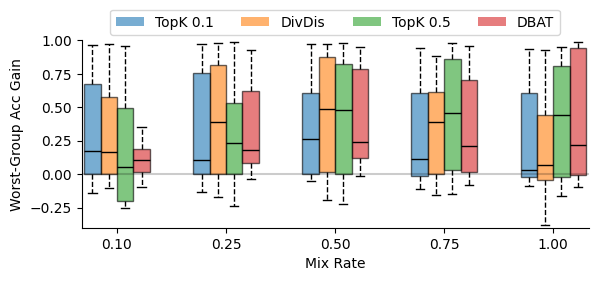

In [16]:
fig, ax = plot_aggregate_metrics(
    df=worst_acc_df,
    included_methods=["TopK_0.1", "DivDis", "TopK_0.5", "DBAT"],
    metric_col='Accuracy',
    ylim=(-0.4, 1.0), 
    figsize=(6, 3), 
    title="", 
    ylabel="Worst-Group Acc Gain", 
    legend_bbox=(0.5, 1.2)
)
fig.savefig(os.path.join(RESULTS_DIR, "worst_acc_boxplot.svg"), bbox_inches="tight", dpi=300)
plt.show()

# No Sched Results

In [17]:
TOPK_METHODS = ["TopK_0.1", "TopK_0.5"]
TOPK_NO_SCHED_METHODS = [
    "TopK_0.1_No_Sched", 
    "TopK_0.5_No_Sched",
]

topk_no_sched_configs = [
    (dataset, method, mix_rate, seed)
    for dataset, method, mix_rate, seed in itertools.product(DATASETS, TOPK_NO_SCHED_METHODS, MIX_RATES, SEEDS)
]


In [18]:
results_topk = df[df['Method'].isin(TOPK_METHODS + ["ERM"])]
results_topk_no_sched = get_results(topk_no_sched_configs, NO_SCHED_DIR)

results_topk_both = pd.concat([results_topk, results_topk_no_sched])

results_topk_both.to_csv(os.path.join(RESULTS_DIR, "results_topk_both.csv"), index=False)


In [19]:
acc_results_sched_ablat = results_topk_both.copy().rename(columns={"acc": "Accuracy"})
alt_acc_results_sched_ablat = results_topk_both.copy().rename(columns={"acc_alt": "Accuracy"})
worst_acc_results_sched_ablat = results_topk_both.copy().rename(columns={"worst_acc": "Accuracy"})

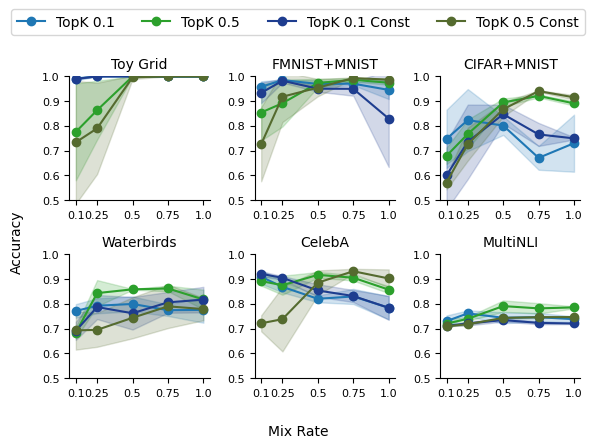

In [20]:
fig, axes = plot_acc_results_grid(
    acc_results_sched_ablat, 
    dataset_titles=DATASET_TITLES, 
    methods=TOPK_METHODS + TOPK_NO_SCHED_METHODS, 
    ylabel="Accuracy", 
    figsize=(6, 4), 
    fontsize=10, 
    tick_fontsize=8, 
    legend_fontsize=8, 
    legend_bbox=(0.5, 1.05)
)
fig.savefig(os.path.join(RESULTS_DIR, "acc_results_sched_ablat_grid.svg"), bbox_inches="tight", dpi=300)
plt.show()

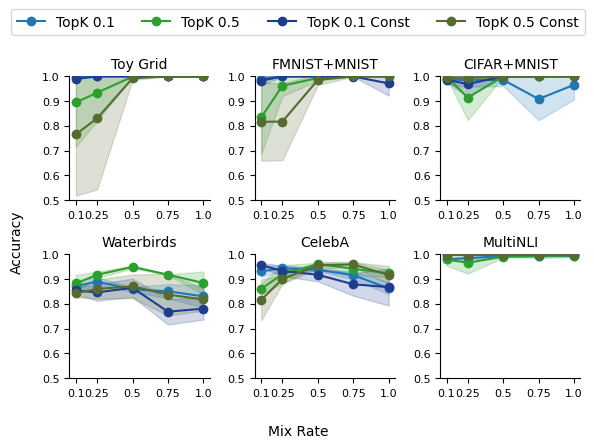

In [21]:
fig, axes = plot_acc_results_grid(
    alt_acc_results_sched_ablat, 
    dataset_titles=DATASET_TITLES, 
    methods=TOPK_METHODS + TOPK_NO_SCHED_METHODS, 
    ylabel="Accuracy", 
    figsize=(6, 4), 
    fontsize=10, 
    tick_fontsize=8, 
    legend_fontsize=8, 
    legend_bbox=(0.5, 1.05)
)
fig.savefig(os.path.join(RESULTS_DIR, "alt_acc_results_sched_ablat_grid.svg"), bbox_inches="tight", dpi=300)
plt.show()

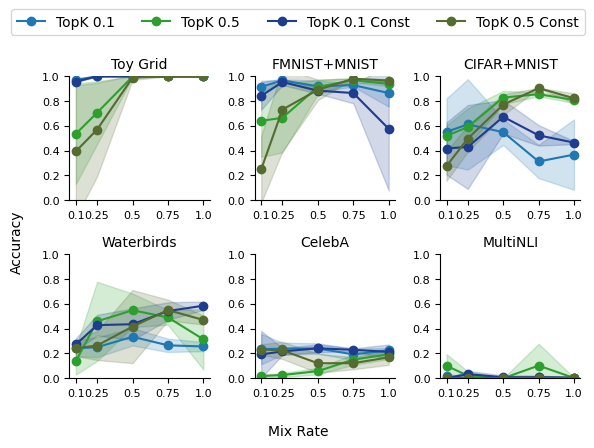

In [22]:
fig, axes = plot_acc_results_grid(
    worst_acc_results_sched_ablat, 
    dataset_titles=DATASET_TITLES, 
    methods=TOPK_METHODS + TOPK_NO_SCHED_METHODS, 
    ylabel="Accuracy", 
    ylim=(0.0, 1.0),
    figsize=(6, 4), 
    fontsize=10, 
    tick_fontsize=8, 
    legend_fontsize=8, 
    legend_bbox=(0.5, 1.05)
)
fig.savefig(os.path.join(RESULTS_DIR, "worst_acc_results_sched_ablat_grid.svg"), bbox_inches="tight", dpi=300)
plt.show()

In [23]:
avg_acc_sched_ablat_df = results_topk_both.copy().rename(columns={"multi_label_acc": "Accuracy"})

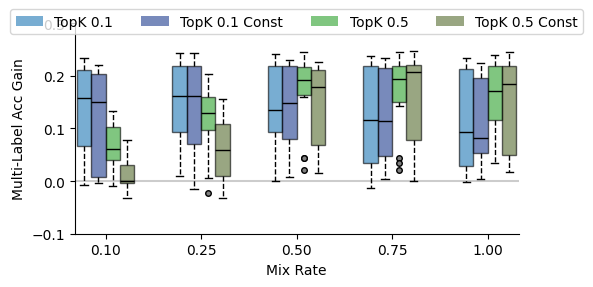

In [24]:
# For average accuracy
fig, ax = plot_aggregate_metrics(
    df=avg_acc_sched_ablat_df,
    included_methods=sorted(TOPK_METHODS + TOPK_NO_SCHED_METHODS),
    metric_col='Accuracy',
    # use_quartiles=False, 
    ylim=(-0.1, 0.3), 
    figsize=(6, 3), 
    width=0.75,
    title="", 
    ylabel="Multi-Label Acc Gain", 
    legend_bbox=(0.5, 1.1)
)
fig.savefig(os.path.join(RESULTS_DIR, "avg_acc_sched_ablat_boxplot.svg"), bbox_inches="tight", dpi=300)
plt.show()

# Combined Results

In [25]:
# TODO: reformat to topk, topk aggregated

TOPK_METHODS = ["TopK_0.1", "TopK_0.5"]
TOPK_INV_AGG_METHODS = [
    "TopK_0.1_Inv_Agg", 
    "TopK_0.5_Inv_Agg",
]

topk_inv_agg_configs = [
    (dataset, method, mix_rate, seed)
    for dataset, method, mix_rate, seed in itertools.product(DATASETS, TOPK_INV_AGG_METHODS, MIX_RATES, SEEDS)
]
results_topk_inv_agg = get_results(topk_inv_agg_configs, INV_AGG_DIR)

results_topk_inv_agg_both = pd.concat([results_topk_inv_agg, results_topk])

In [26]:
# if in ["toy_grid", "cifar_mnist", "fmnist_mnist"], rename Inv_Agg to Agg 
# else rename Inv_Agg to "", TopK to "Agg"

# Define the datasets for different renaming rules
synthetic_datasets = ["toy_grid", "cifar_mnist", "fmnist_mnist"]

# Define a function to apply the renaming rules
def rename_method(row):
    method = row['Method']
    dataset = row['Dataset']
    
    if dataset in synthetic_datasets:
        # For synthetic datasets: rename "Inv_Agg" to "Agg"
        return method.replace("_Inv_Agg", "_Comb") if "_Inv_Agg" in method else method
    else:
        # For other datasets: remove "_Inv_Agg" suffix or add "_Agg" suffix to original TopK
        if "_Inv_Agg" in method:
            return method.replace("_Inv_Agg", "")
        elif method in TOPK_METHODS:
            return method + "_Comb"
        return method

# Apply the renaming function to create a new DataFrame
results_topk_agg_both = results_topk_inv_agg_both.assign(Method=results_topk_inv_agg_both.apply(rename_method, axis=1))

# Print unique method names to verify the transformation
print("Renamed method names:", sorted(results_topk_agg_both['Method'].unique()))
TOPK_AGG_METHODS = [
    "TopK_0.1_Comb", 
    "TopK_0.5_Comb",
]

Renamed method names: ['ERM', 'TopK_0.1', 'TopK_0.1_Comb', 'TopK_0.5', 'TopK_0.5_Comb']


In [27]:

results_topk_agg_both.to_csv(os.path.join(RESULTS_DIR, "results_topk_agg_both.csv"), index=False)

acc_results_topk_agg = results_topk_agg_both.copy().rename(columns={"acc": "Accuracy"})
alt_acc_results_topk_agg = results_topk_agg_both.copy().rename(columns={"acc_alt": "Accuracy"})
worst_acc_results_topk_agg = results_topk_agg_both.copy().rename(columns={"worst_acc": "Accuracy"})


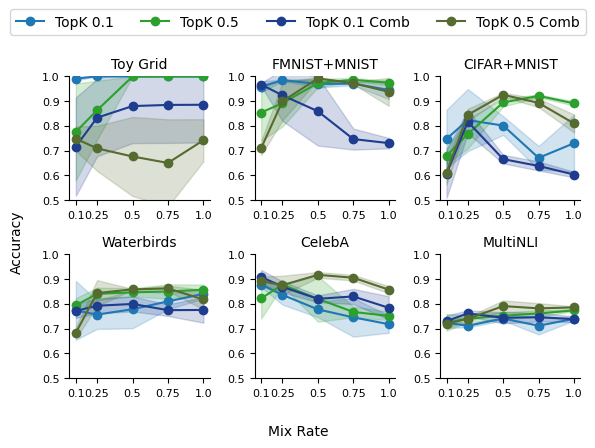

In [28]:
fig, axes = plot_acc_results_grid(
    acc_results_topk_agg, 
    dataset_titles=DATASET_TITLES, 
    methods=TOPK_METHODS + TOPK_AGG_METHODS, 
    ylabel="Accuracy", 
    figsize=(6, 4), 
    fontsize=10, 
    tick_fontsize=8, 
    legend_fontsize=8, 
    legend_bbox=(0.5, 1.05)
)
fig.savefig(os.path.join(RESULTS_DIR, "acc_results_agg_grid.svg"), bbox_inches="tight", dpi=300)
plt.show()

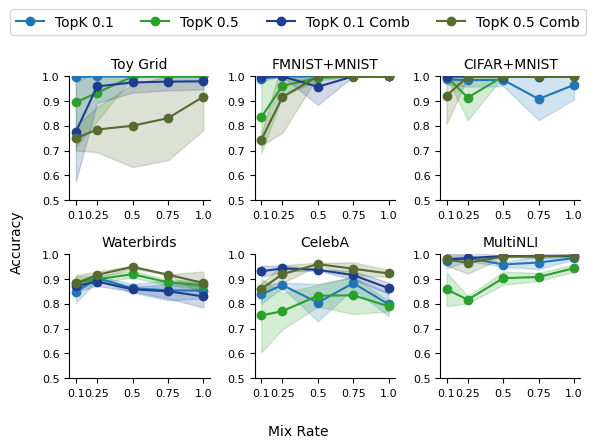

In [29]:
fig, axes = plot_acc_results_grid(
    alt_acc_results_topk_agg, 
    dataset_titles=DATASET_TITLES, 
    methods=TOPK_METHODS + TOPK_AGG_METHODS, 
    ylabel="Accuracy", 
    figsize=(6, 4), 
    fontsize=10, 
    tick_fontsize=8, 
    legend_fontsize=8, 
    legend_bbox=(0.5, 1.05)
)
fig.savefig(os.path.join(RESULTS_DIR, "alt_acc_results_agg_grid.svg"), bbox_inches="tight", dpi=300)
plt.show()

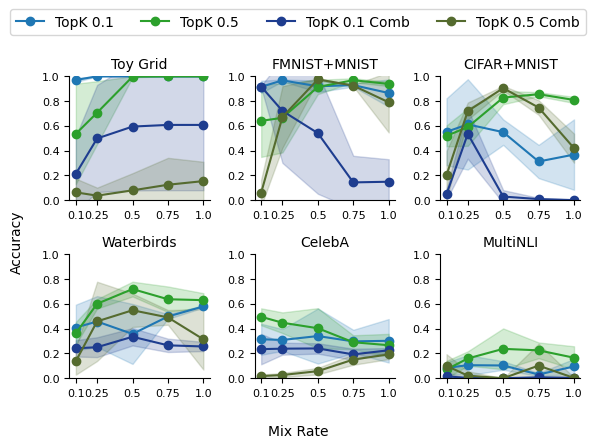

In [30]:
fig, axes = plot_acc_results_grid(
    worst_acc_results_topk_agg, 
    dataset_titles=DATASET_TITLES, 
    methods=TOPK_METHODS + TOPK_AGG_METHODS, 
    ylabel="Accuracy", 
    ylim=(0.0, 1.0),
    figsize=(6, 4), 
    fontsize=10, 
    tick_fontsize=8, 
    legend_fontsize=8, 
    legend_bbox=(0.5, 1.05)
)
fig.savefig(os.path.join(RESULTS_DIR, "worst_acc_results_agg_grid.svg"), bbox_inches="tight", dpi=300)
plt.show()

In [31]:
avg_acc_agg_df = results_topk_agg_both.copy().rename(columns={"multi_label_acc": "Accuracy"})

avg_acc_agg_df.to_csv(os.path.join(RESULTS_DIR, "avg_acc_agg_df.csv"), index=False)

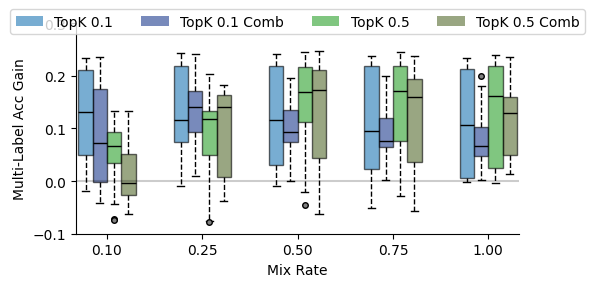

In [32]:
# For average accuracy
fig, ax = plot_aggregate_metrics(
    df=avg_acc_agg_df,
    included_methods=sorted(TOPK_METHODS + TOPK_AGG_METHODS),
    metric_col='Accuracy',
    # use_quartiles=False, 
    ylim=(-0.1, 0.3), 
    figsize=(6, 3), 
    width=0.75,
    title="", 
    ylabel="Multi-Label Acc Gain", 
    legend_bbox=(0.5, 1.1)
)
fig.savefig(os.path.join(RESULTS_DIR, "avg_acc_agg_boxplot.svg"), bbox_inches="tight", dpi=300)
plt.show()

# Val Loss Test Acc Correlation

In [33]:
DATASET_ORDER = ["fmnist_mnist", "cifar_mnist", "waterbirds", "celebA-0", "multi-nli"]

In [41]:
from typing import Literal
def plot_metric_correlations(
    df: pd.DataFrame,
    figsize: tuple[float, float] = (6, 8),
    acc_metric: Literal["acc", "alt", "multi_label", "worst"] = "acc",
    model_selection_metric: str = "val_loss",
    ylabel: str = 'Test Accuracy',
    xlabel: str = 'Validation Loss',
):
    # Get unique values for grouping
    methods = sorted(df['Method'].unique())
    datasets = [ds for ds in DATASET_ORDER if ds in df['Dataset'].unique()]
    
    # Create figure with subplots - one column per method
    n_datasets = len(datasets)
    n_methods = len(methods)
    fig, axes = plt.subplots(n_datasets, n_methods, figsize=figsize)

    # Get viridis colormap
    cmap = plt.cm.viridis
    mix_rates = sorted(df['Mix_Rate'].unique())
    colors = [cmap(i) for i in np.linspace(0, 1, len(mix_rates))]
    mix_rate_to_color = dict(zip(mix_rates, colors))

    corr_coefs = []
    
    # Process each dataset's data
    for dataset_idx, dataset in enumerate(datasets):
        dataset_df = df[df['Dataset'] == dataset].copy()
        
        # Process each method
        for method_idx, method in enumerate(methods):
            method_df = dataset_df[dataset_df['Method'] == method].copy()
            ax = axes[dataset_idx, method_idx]
            
            if not method_df.empty:
                # Plot and calculate correlation for each mix rate
                for mix_rate, group in method_df.groupby('Mix_Rate'):
                    if len(group) > 1:  # Need at least 2 points for correlation
                        acc = group[acc_metric]
                        r = np.corrcoef(group[model_selection_metric], acc)[0,1]
                        corr_coefs.append({
                            "dataset": dataset,
                            "method": method,
                            "mix_rate": mix_rate,
                            "r": r
                        })
                        
                        # Plot with mix rate in label - more compact format
                        scatter = ax.scatter(
                            group[model_selection_metric], 
                            acc, 
                            label=f'{mix_rate:.2f}|{r:.2f}',  # Shortened label format
                            alpha=0.5, 
                            color=mix_rate_to_color[mix_rate]
                        )
            
            # Set titles and labels
            if dataset_idx == 0:
                ax.set_title(method, fontsize='small')
            if method_idx == 0:
                ax.set_ylabel(f'{DATASET_TITLES[dataset]}\n{ylabel}', fontsize='small')
            if dataset_idx == n_datasets - 1:
                ax.set_xlabel(f'{xlabel}', fontsize='small')
            
            # Styling
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.tick_params(axis='both', which='major', labelsize='x-small')
            
            # Add legend with smaller font and more compact layout
            ax.legend(
                fontsize='xx-small',
                title='mix|r',  # Add title to explain format
                title_fontsize='xx-small',
                ncol=2,  # Use 2 columns to make legend more compact
                loc='best',
                borderaxespad=0.1,  # Reduce padding around legend
                handletextpad=0.3,  # Reduce space between marker and text
                columnspacing=0.5,  # Reduce space between columns
            )
    corr_coefs_df = pd.DataFrame(corr_coefs)
    
    plt.tight_layout()
    return fig, axes, corr_coefs_df

In [35]:
df_per_epoch = get_results(configs, MAIN_DIR, select_epoch=False)
df_per_epoch["multi_label_err"] = 1 - df_per_epoch["multi_label_acc"]

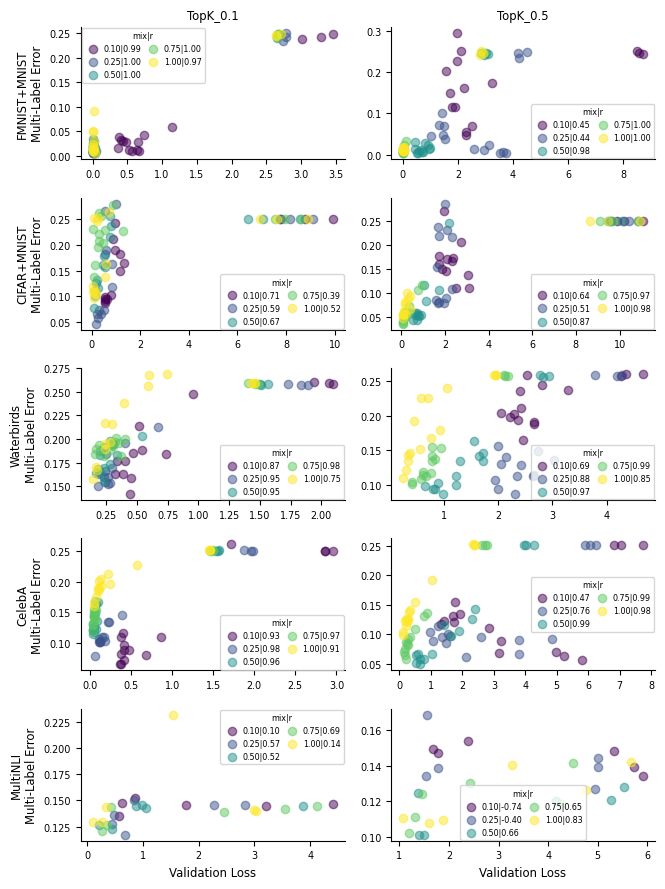

In [36]:
# get epoch level data # TODO:
fig, axes, corr_coefs_df_topk = plot_metric_correlations(
    df_per_epoch[
        df_per_epoch["Method"].isin(["TopK_0.1", "TopK_0.5"]) & (df_per_epoch["Dataset"] != "toy_grid")], 
    acc_metric="multi_label_err",
    ylabel="Multi-Label Error",
    figsize=(6.75, 9)
)
fig.savefig(os.path.join(RESULTS_DIR, "topk_correlations.svg"), bbox_inches="tight", dpi=300)
plt.show()

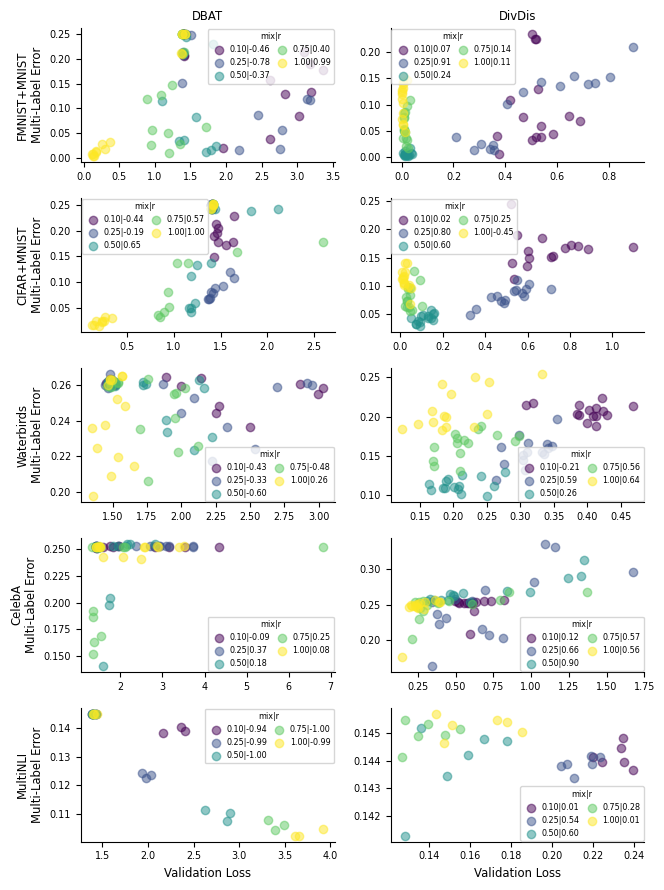

In [37]:
fig, axes, corr_coefs_df_divdis_dbat = plot_metric_correlations(
    df_per_epoch[df_per_epoch["Method"].isin(["DivDis", "DBAT"]) & (df_per_epoch["Dataset"] != "toy_grid")], 
    acc_metric="multi_label_err",
    ylabel="Multi-Label Error",
    figsize=(6.75, 9)
)
fig.savefig(os.path.join(RESULTS_DIR, "divdis_dbat_correlations.svg"), bbox_inches="tight", dpi=300)

In [38]:
corr_coefs_df = pd.concat([corr_coefs_df_topk, corr_coefs_df_divdis_dbat])


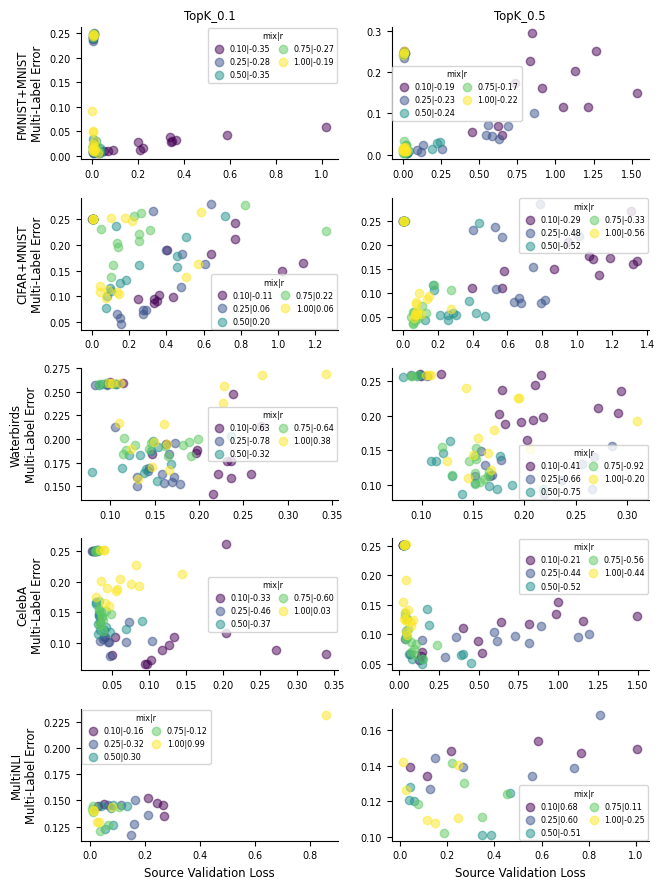

In [43]:
fig, axes, corr_coefs_source_df_topk = plot_metric_correlations(
    df_per_epoch[
        df_per_epoch["Method"].isin(["TopK_0.1", "TopK_0.5"]) & (df_per_epoch["Dataset"] != "toy_grid")], 
    acc_metric="multi_label_err",
    ylabel="Multi-Label Error",
    model_selection_metric="source_loss",
    xlabel="Source Validation Loss",
    figsize=(6.75, 9)
)
fig.savefig(os.path.join(RESULTS_DIR, "topk_correlations.svg"), bbox_inches="tight", dpi=300)
plt.show()

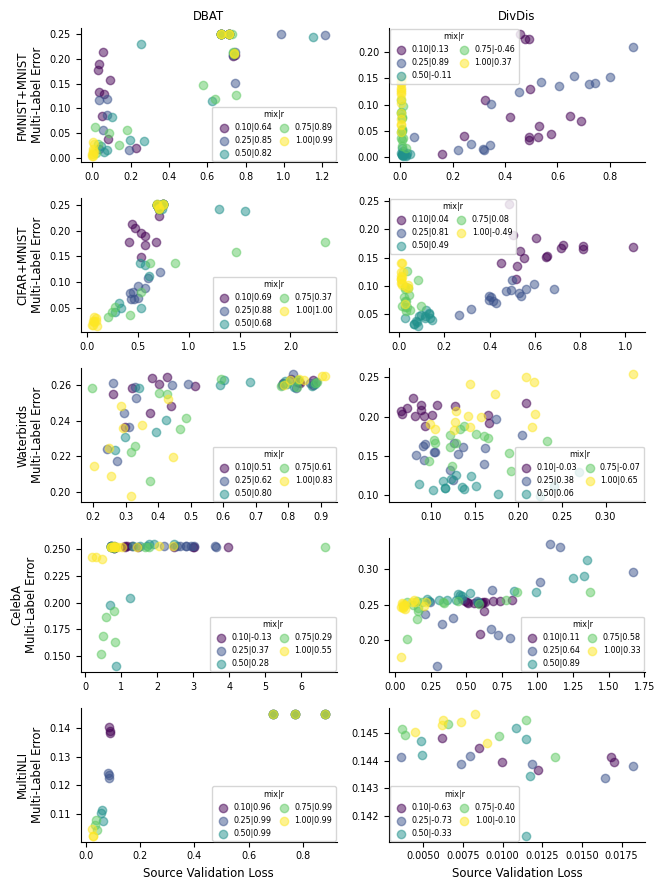

In [44]:
fig, axes, corr_coefs_source_df_divdis = plot_metric_correlations(
    df_per_epoch[
        df_per_epoch["Method"].isin(["DivDis", "DBAT"]) & (df_per_epoch["Dataset"] != "toy_grid")], 
    acc_metric="multi_label_err",
    ylabel="Multi-Label Error",
    model_selection_metric="source_loss",
    xlabel="Source Validation Loss",
    figsize=(6.75, 9)
)
fig.savefig(os.path.join(RESULTS_DIR, "topk_correlations.svg"), bbox_inches="tight", dpi=300)
plt.show()

In [45]:
corr_coefs_source_df = pd.concat([corr_coefs_source_df_topk, corr_coefs_source_df_divdis])

In [ ]:
def plot_correlation_violins(
    corr_df: pd.DataFrame,
    figsize: tuple[float, float] = (6, 3),
    ylim: tuple[float, float] = (-1.0, 1.0),
    width: float = 0.75,
    ylabel: str = 'Correlation Coefficient',
    method_colors: dict[str, str] = METHOD_COLORS,
    legend_bbox: tuple[float, float] = (0.5, 1.1),
):
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Set y-limits
    ax.set_ylim(ylim)

    # Get unique methods and mix rates
    methods = sorted(corr_df['method'].unique())
    mix_rates = sorted(corr_df['mix_rate'].unique())
    
    # Calculate positions for violin plots
    x = np.arange(len(mix_rates))
    x = x * (len(methods) + 1)  # Increase spacing between mix rate groups
    
    # Plot violins for each method
    violin_positions = []
    violin_data = []
    colors = []
    
    for i, method in enumerate(methods):
        for j, mix_rate in enumerate(mix_rates):
            data = corr_df[(corr_df['method'] == method) & 
                         (corr_df['mix_rate'] == mix_rate)]['r']
            if len(data) > 0:
                pos = x[j] + width * (i - len(methods)/2 + 0.5)
                violin_positions.append(pos)
                violin_data.append(data)
                colors.append(method_colors[method])

    # Create violin plot
    violins = ax.violinplot(violin_data, positions=violin_positions, widths=width, showmedians=True)
    
    # Color the violins according to method
    for i, (pc, color) in enumerate(zip(violins['bodies'], colors)):
        pc.set_facecolor(color)
        pc.set_alpha(0.6)
        pc.set_edgecolor('black')
        pc.set_linewidth(1)
    
    # Style the violin plot elements
    for partname in ('cbars', 'cmins', 'cmaxes'):
        vp = violins[partname]
        vp.set_visible(False)
        # vp.set_edgecolor('black')
        # vp.set_linewidth(1)
    print(violins.keys())
    violins['cmedians'].set_color('black')
    violins['cmedians'].set_linewidth(1)
    
    # Add horizontal line at y=0
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.2)
    
    # Set title and labels
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Mix Rate')
    
    # Update x-axis ticks
    ax.set_xticks(x)
    ax.set_xticklabels([f'{mr:.2f}' for mr in mix_rates], rotation=0)
    
    # Style the plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Create custom legend
    legend_elements = [Patch(facecolor=method_colors[method], alpha=0.6, 
                           label=METHOD_TITLES[method])
                      for method in methods]
    ax.legend(handles=legend_elements, bbox_to_anchor=legend_bbox, 
             loc='upper center', ncol=len(methods))

    plt.tight_layout()
    
    return fig, ax

dict_keys(['bodies', 'cmaxes', 'cmins', 'cbars', 'cmedians'])


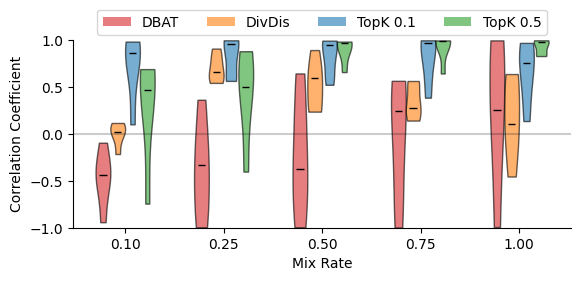

In [46]:

fig, ax = plot_correlation_violins(
    corr_coefs_df[corr_coefs_df["dataset"] != "toy_grid"],
    figsize=(6,3),
    ylim=(-1.0, 1.0),
    ylabel="Correlation Coefficient", 
    legend_bbox=(0.5, 1.2)
)
plt.savefig(os.path.join(RESULTS_DIR, "corr_coef_violin.svg"), 
            bbox_inches="tight", dpi=300)
plt.show()

dict_keys(['bodies', 'cmaxes', 'cmins', 'cbars', 'cmedians'])


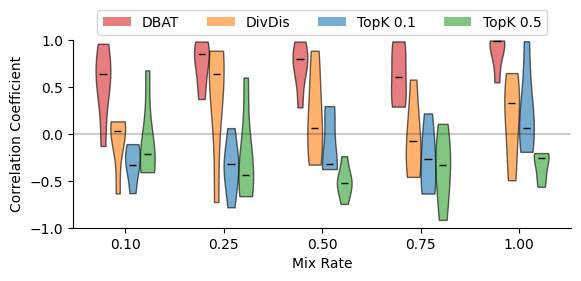

In [47]:
fig, ax = plot_correlation_violins(
    corr_coefs_source_df[corr_coefs_source_df["dataset"] != "toy_grid"],
    figsize=(6,3),
    ylim=(-1.0, 1.0),
    ylabel="Correlation Coefficient", 
    legend_bbox=(0.5, 1.2)
)
plt.savefig(os.path.join(RESULTS_DIR, "corr_coef_source_violin.svg"), 
            bbox_inches="tight", dpi=300)
plt.show()